In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input,LSTM
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
smp = pd.read_csv('../data/smp.csv')

smp['date'] = pd.to_datetime(smp['date'])
smp['day_of_week'] = smp['date'].dt.dayofweek

In [4]:
smp.head()

,date,smp_max,smp_min,smp_mean,day_of_week
0,2018-01-01,95.93,73.69,84.88,0
1,2018-01-02,95.70,88.36,92.57,1
2,2018-01-03,96.47,88.37,92.34,2
3,2018-01-04,98.09,88.37,92.14,3
4,2018-01-05,96.12,88.23,92.42,4


In [5]:
smp.shape

(820, 5)

In [6]:
smp['day_of_week'] = smp['day_of_week'].astype('category')
smp = pd.get_dummies(smp, columns = ['day_of_week'], prefix='W', drop_first=True) # one hot encoding

In [7]:
smp.head()

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
0,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
1,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
2,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
3,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
4,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0


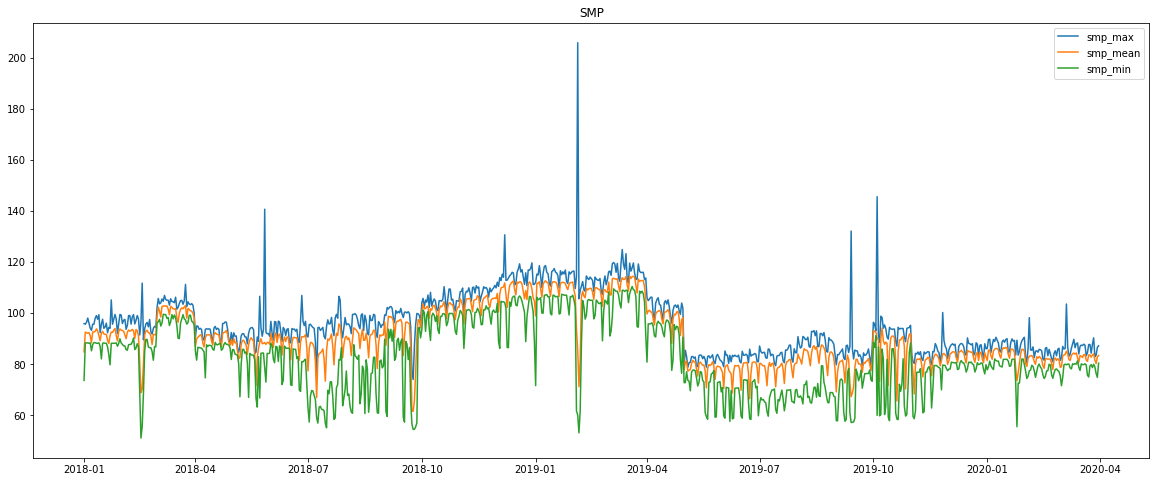

In [12]:
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(20,8))
plt.plot(smp['date'], smp['smp_max'], label='smp_max')
plt.plot(smp['date'], smp['smp_mean'], label='smp_mean')
plt.plot(smp['date'], smp['smp_min'], label='smp_min')
plt.title('SMP')
plt.legend()


In [13]:
# Settings
train_split_idx = 729   # 2020.1.1. 행 인덱스 번호  
window_size = 10   # 과거 10일 동안의 시계열 데이터를 학습 데이터로 사용
future = 3     # 3일 이후의 타겟을 예측

# Features 
X_train = smp.iloc[:train_split_idx - window_size - future, 0:]   

# Targets
y_train = smp.iloc[window_size + future :train_split_idx, [3]]  # 'smp_mean' 열

print(X_train.shape, y_train.shape)

(716, 10) (716, 1)


In [14]:
# X_test
test_start = train_split_idx - window_size - future  # 테스트 데이터의 시작 행  
test_end = smp.shape[0] - window_size - future
X_test = smp.iloc[test_start:test_end, 0:]

# y_test
# label_start =  + future # 테스트 데이터의 첫 번째 타겟 데이터 위치 
y_test = smp.iloc[train_split_idx:, [3]]  # 'smp_mean' 열 선택

print(X_test.shape, y_test.shape)

(91, 10) (91, 1)


In [15]:
# Feature Scaling
X_train_scaled = X_train.loc[:, 'smp_max':]
X_test_scaled = X_test.loc[:, 'smp_max':]

scaler=MinMaxScaler()
scaler.fit(X_train_scaled.values)

X_train_scaled.loc[:, :] = scaler.transform(X_train_scaled.values)
X_test_scaled.loc[:, :] = scaler.transform(X_test_scaled.values)

In [17]:
# Mini Batch 크기로 시계열을 변환

train_data = timeseries_dataset_from_array( 
    X_train_scaled, y_train, sequence_length=window_size, batch_size=16)
test_data = timeseries_dataset_from_array( 
    X_test_scaled, y_test, sequence_length=window_size, batch_size=16)

print(train_data)
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [18]:
for batch in test_data.take(1):
    inputs, targets = batch

print("Input:", inputs.numpy().shape)
print("Target:", targets.numpy().shape)

Input: (16, 10, 9)
Target: (16, 1)


In [19]:
inputs[0]

<tf.Tensor: shape=(10, 9), dtype=float64, numpy=
array([[0.10309278, 0.50160013, 0.43581017, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.10657975, 0.48846219, 0.43996975, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.07148272, 0.48391443, 0.39289091, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.07921468, 0.43540509, 0.36245037, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.10923287, 0.45645949, 0.42673473, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10513948, 0.49671551, 0.4342976 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.06958763, 0.48425131, 0.37700889, 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10097029, 0.48694627, 0.4369446 , 0.        , 0.        ,
        

In [20]:
targets[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([81.46])>

In [22]:
model = Sequential()
model.add(Input(shape=[10, 9]))

model.add(LSTM(units=32, return_sequences=False)) 
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


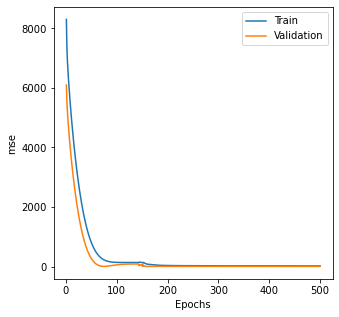

In [24]:
# 모델 훈련
history = model.fit(train_data, epochs=500, 
                    validation_data=test_data)

# 손실 함수 그래프
def plot_loss_curve(history, total_epoch=10, start=1):
    plt.figure(figsize=(5, 5))
    plt.plot(range(start, total_epoch + 1), 
             history.history['loss'][start-1:total_epoch], 
             label='Train')
    plt.plot(range(start, total_epoch + 1), 
             history.history['val_loss'][start-1:total_epoch], 
             label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

plot_loss_curve(history=history, 
                total_epoch=len(history.history['loss']), start=1)                   

In [28]:
y_pred = model.predict(test_data)
y_pred.shape

(82, 1)

,smp_mean
729,81.46
730,85.51
731,85.63
732,83.26
733,81.95
...,...
806,82.68
807,83.79
808,83.80
809,81.69


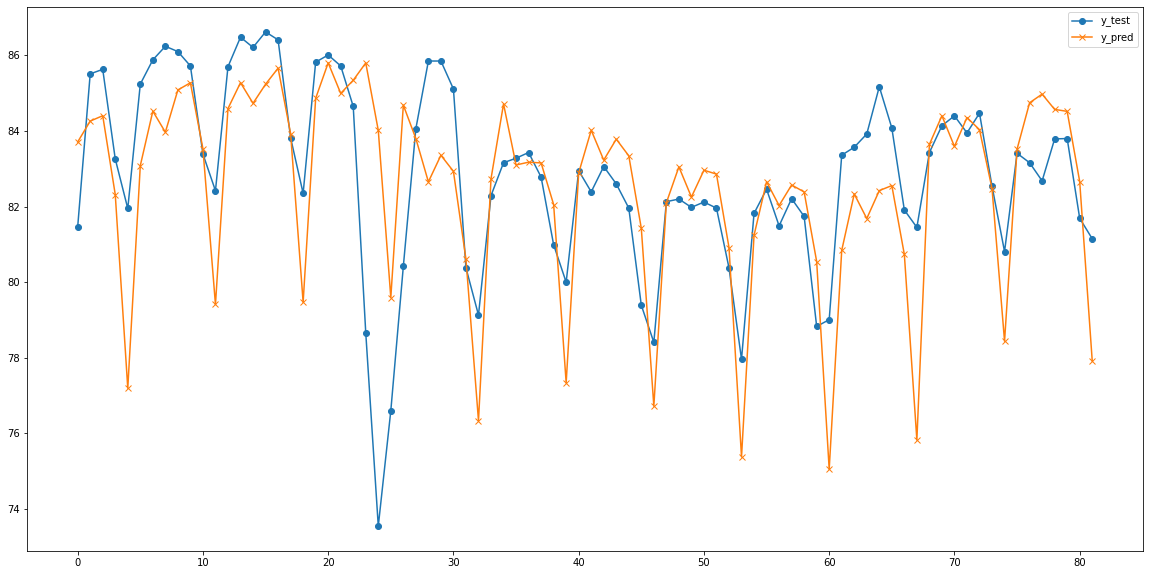

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_test[:-(window_size-1)].values, marker='o', label='y_test')
plt.plot(range(len(y_pred)), y_pred, marker='x', label='y_pred')
plt.legend()
plt.show()